## Import

In [58]:
import os, io, gc, glob
import numpy as np
import pandas as pd
import random

from scipy.fft import fft
from scipy.signal import hilbert, blackman
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten ,Dropout, Activation
from tensorflow.keras.layers import Add, concatenate
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')
gc.enable()

In [59]:
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

## Fix Seed

In [60]:
SEED = 42
def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
seed_everything()

## Hyperparameter Setting

In [61]:
# Model Configuration
class CFG:
    seed = 42
    VERBOSE = 1
    random_state = 42
    N_FOLDS = 3
    EPOCHS = 200
    WINDOW_SIZE = 24
    BATCH_SIZE = 16
    factor = 0.5
    patience_1 = 5
    patience_2 = 15
    learning_rate = 1e-3
    weight_decay = 1e-3
    dropout_rate = 0.2

## Data Scope Setting

In [80]:
class SCOPE:
    AVG_TEMP_PER_HOUR = (4.0,40.0) # 시간당 내부 평균온도
    AVG_HUMI_PER_HOUR = (0.0,100.0) # 시간당 내부 평균습도
    AVG_CO2_PER_HOUR = (0.0,1200.0) # 시간당 내부 평균 co2 농도
    AVG_EC_PER_HOUR = (0.0,8.0) # 시간당 평균 EC
    WATER_PER_HOUR = (0.0,3000.0) # 시간당 분무량
    WATER_PER_DAY = (0.0,72000.0) # 일간 누적 분무량
    LIGHT_PER_HOUR = (0.0,120000.0) # 시간당 광량 (백색,적색,청색,총 모두다 동일)
    LIGHT_PER_DAY = (0.0, 2880000.0) # 일간 누적 광량 (백색,적색,청색,총 모두다 동일)

## Data loading

In [62]:
all_input_list = sorted(glob.glob('./data/train_input/*.csv'))
all_target_list = sorted(glob.glob('./data/train_target/*.csv'))

df_train_input = pd.concat(map(pd.read_csv, all_input_list)).drop(columns='obs_time')
df_train_target = pd.concat(map(pd.read_csv, all_target_list)).drop(columns='DAT')

## Data preprocessing 

In [76]:
df_train_input.shape

(18816, 15)

In [77]:
df_train_input.dropna(axis=0, inplace=True)
df_train_input.shape

(18816, 15)

In [78]:
df_train_input.describe()

,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
count,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000
mean,13.500000,26.027719,63.935090,498.860695,1.507566,523.627918,6365.916673,6315.562930,72910.240149,1571.862912,18201.358998,1241.905981,14139.184959,9129.331824,105250.784106
std,8.077962,3.948988,11.657905,120.421248,1.042010,544.323281,6903.680044,8188.067575,86040.447105,2937.252667,34386.384982,2474.426437,27743.227265,9175.427411,97397.224913
min,0.000000,0.000000,0.000000,60.400000,0.000000,-653.260000,0.000000,-138371.246100,0.000000,-8793.607200,0.000000,-18570.857500,0.000000,-165735.710800,0.000000
25%,6.750000,23.971250,57.494583,420.245833,0.929581,0.000000,1234.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7280.962850
50%,13.500000,26.291667,62.118333,473.983333,1.308517,252.000000,3360.485000,0.000000,23205.750000,0.000000,0.000000,0.000000,0.000000,9242.350000,92172.360000
75%,20.250000,28.106667,73.157166,551.105952,2.291322,769.000000,9990.570000,18236.625400,145422.700000,1494.698100,17529.296400,1306.461000,18484.700000,18255.190000,177491.499450
max,27.000000,42.643334,93.350002,1714.850000,5.462324,3144.130000,42855.230000,18564.600000,292014.969800,9928.800000,200561.760000,9399.000000,190016.450000,37892.400000,559488.881000


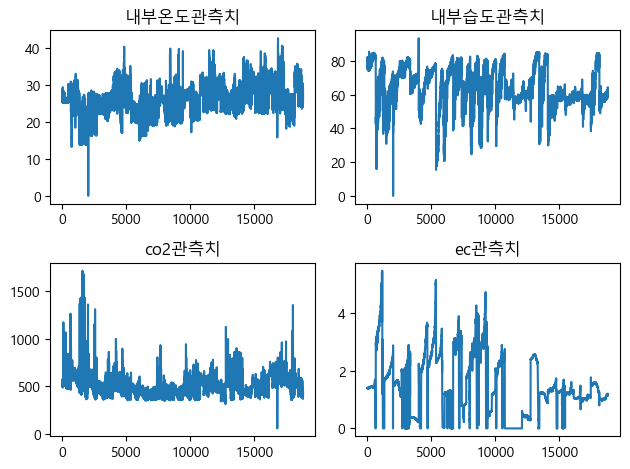

In [83]:
x = range(df_train_input.shape[0])

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(x, df_train_input['내부온도관측치'])
ax[0, 1].plot(x, df_train_input['내부습도관측치'])
ax[1, 0].plot(x, df_train_input['co2관측치'])
ax[1, 1].plot(x, df_train_input['ec관측치'])

ax[0, 0].set_title("내부온도관측치")
ax[0, 1].set_title("내부습도관측치")
ax[1, 0].set_title("co2관측치")
ax[1, 1].set_title("ec관측치")

fig.tight_layout()
plt.show()

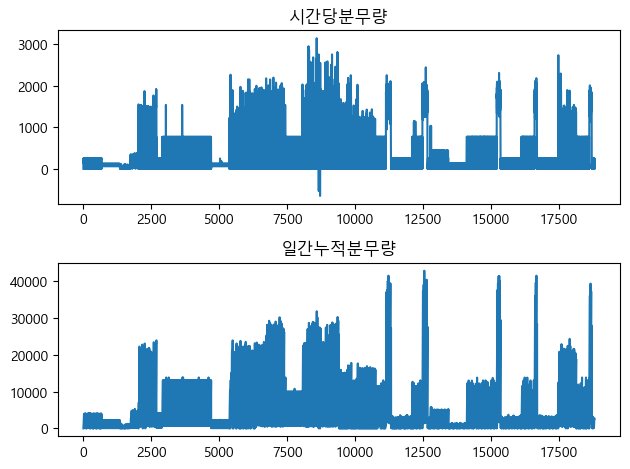

In [89]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(x, df_train_input['시간당분무량'])
ax[1].plot(x, df_train_input['일간누적분무량'])

ax[0].set_title("시간당분무량")
ax[1].set_title("일간누적분무량")

fig.tight_layout()
plt.show()

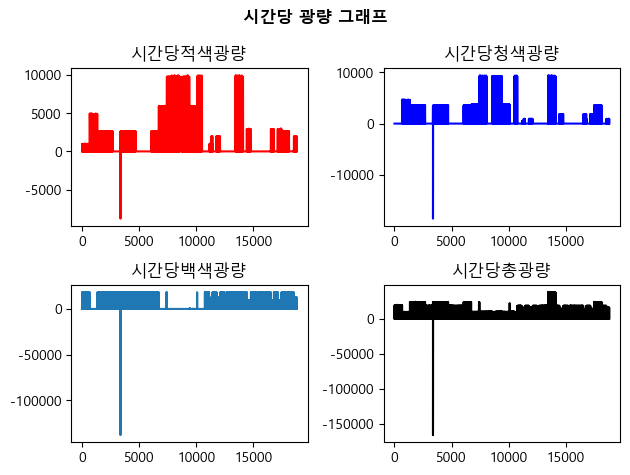

In [67]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(x, df_train_input['시간당적색광량'],'r-')
ax[0, 1].plot(x, df_train_input['시간당청색광량'],'b-')
ax[1, 0].plot(x, df_train_input['시간당백색광량'])
ax[1, 1].plot(x, df_train_input['시간당총광량'],color='black')

ax[0, 0].set_title("시간당적색광량")
ax[0, 1].set_title("시간당청색광량")
ax[1, 0].set_title("시간당백색광량")
ax[1, 1].set_title("시간당총광량")

fig.suptitle('시간당 광량 그래프',fontweight ="bold") 

fig.tight_layout()
plt.show()

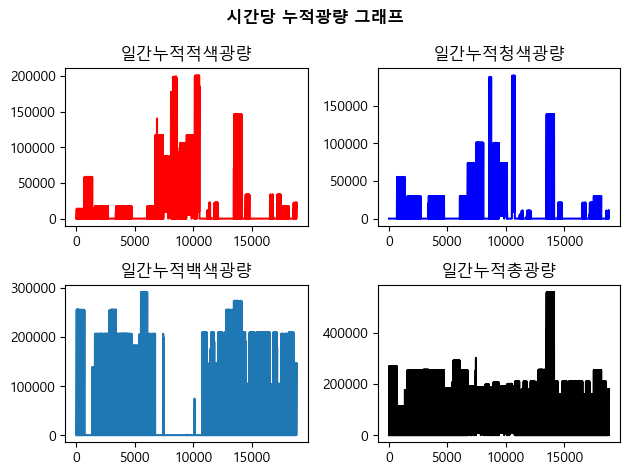

In [69]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(x, df_train_input['일간누적적색광량'],'r-')
ax[0, 1].plot(x, df_train_input['일간누적청색광량'],'b-')
ax[1, 0].plot(x, df_train_input['일간누적백색광량'])
ax[1, 1].plot(x, df_train_input['일간누적총광량'],color='black')

ax[0, 0].set_title("일간누적적색광량")
ax[0, 1].set_title("일간누적청색광량")
ax[1, 0].set_title("일간누적백색광량")
ax[1, 1].set_title("일간누적총광량")

fig.suptitle('시간당 누적광량 그래프',fontweight ="bold") 

fig.tight_layout()
plt.show()

In [72]:
df_train_input[df_train_input['시간당적색광량'] < 0]

,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
15,0,27.384,74.1,410.12,0.388644,769.0,9228.0,-138371.2461,7116.43,-8793.6072,688.3968,-18570.8575,1372.254,-165735.7108,9177.0808


In [5]:
# Dataset 로드 함수

def windowed_dataset(x,y,window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, stride=1, shift=window_size, drop_remainder=False)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 window dataset 구성
    ds_y = tf.data.Dataset.from_tensor_slices(y)
    ds = tf.data.Dataset.zip((ds_x,ds_y))
    if shuffle:
        ds = ds.shuffle(SEED)
    return ds.batch(batch_size).prefetch(1)

In [6]:
train_data = windowed_dataset(df_train_input,df_train_target,CFG.WINDOW_SIZE,CFG.BATCH_SIZE, True)

In [7]:
# 아래의 코드로 데이터셋의 구성 확인 가능
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size,window_size,feature개수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size,window_size,feature개수): {data[1].shape}')

데이터셋(X) 구성(batch_size,window_size,feature개수): (16, 24, 15)
데이터셋(Y) 구성(batch_size,window_size,feature개수): (16, 1)


## Model define

In [8]:
def dnn_model():
    x_input = Input(shape=[CFG.WINDOW_SIZE,15])
    
    x1 = Bidirectional(LSTM(units=1024, return_sequences=True))(x_input)
    c1 = concatenate([x_input, x1])
    
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(c1)
    c2 = concatenate([x1, x2])
    
    x3 = Bidirectional(LSTM(units=256, return_sequences=True))(c2)
    c3 = concatenate([x2, x3])
    
    x4 = Bidirectional(LSTM(units=128, return_sequences=True))(c3)
    c4 = concatenate([x3, x4])
    
    x5 = Dense(units=128, activation='selu')(c4)
    x6 = Flatten()(x5)
    x7 = Dense(units=64, activation='selu')(x6)
    x_output = Dense(units=1, activation='linear')(x7
    
    model = Model(inputs=x_input, outputs=x_output, name='DNN_Model')
    model.compile(optimizer='Adam', loss='mae')
    
    return model

In [9]:
test_preds = []
history_list = []
oof_true = []
oof_pred = []

## KFold cross-validation

In [12]:
kf = KFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=SEED)

train_input = df_train_input.to_numpy().reshape(-1,CFG.WINDOW_SIZE,15)
train_target = df_train_target.to_numpy()

# Scaler
MMS = MinMaxScaler(feature_range=(0.0,1.0))

for fold, (train_idx, test_idx) in enumerate(kf.split(train_input)):
    print('='*25, '>', f'Fold {fold+1}', '<', '='*25)
    checkpoint_filepath = f'fold{fold+1}.hdf5'
    
    X_train, X_valid = train_input[train_idx], train_input[test_idx]
    y_train, y_valid = train_target[train_idx], train_target[test_idx]
    
    # data scaling
    X_train = X_train.reshape(-1,15)
    X_valid = X_valid.reshape(-1,15)
    X_train = MMS.fit_transform(X_train)
    X_valid = MMS.transform(X_valid)
    train_data = windowed_dataset(X_train,y_train,CFG.WINDOW_SIZE,CFG.BATCH_SIZE, True)
    valid_data = windowed_dataset(X_valid,y_valid,CFG.WINDOW_SIZE,CFG.BATCH_SIZE, True)
        
    lr = ReduceLROnPlateau(monitor="val_loss", factor=CFG.factor, patience=CFG.patience_1,
                               verbose=CFG.VERBOSE)
    es = EarlyStopping(monitor="val_loss", patience=CFG.patience_2, mode="min",
                           restore_best_weights=True, verbose=CFG.VERBOSE)
    sv = ModelCheckpoint(checkpoint_filepath, monitor = 'val_loss', verbose = CFG.VERBOSE,
                             save_best_only = True, save_weights_only = True, mode = 'min')
        
    model = dnn_model()
    history = model.fit(train_data,
                        validation_data=valid_data,
                        epochs=CFG.EPOCHS, batch_size=CFG.BATCH_SIZE, callbacks=[lr,es,sv])        
    history_list += [history]
        
    # predict
    y_pred = model.predict(X_valid.reshape(-1,CFG.WINDOW_SIZE,15))
    y_true = y_valid
        
    ## inspiratory and expiratory phases
    score = mean_absolute_error(y_true, y_pred)
    print(f'Fold {fold+1} | Overall MAE Score: {score}')
        
    del X_train, X_valid, y_train, y_valid
    gc.collect()

========================= > Fold 1 < =========================
Epoch 1/200
46/46 [==============================] - 9s 68ms/step - loss: 25.8890 - val_loss: 20.8814

Epoch 00001: val_loss improved from inf to 20.88138, saving model to fold1.hdf5
Epoch 2/200
46/46 [==============================] - 2s 39ms/step - loss: 21.6579 - val_loss: 19.6976

Epoch 00002: val_loss improved from 20.88138 to 19.69758, saving model to fold1.hdf5
Epoch 3/200
46/46 [==============================] - 2s 39ms/step - loss: 23.5013 - val_loss: 29.7858

Epoch 00003: val_loss did not improve from 19.69758
Epoch 4/200
46/46 [==============================] - 2s 38ms/step - loss: 28.6685 - val_loss: 29.4581

Epoch 00004: val_loss did not improve from 19.69758
Epoch 5/200
46/46 [==============================] - 2s 39ms/step - loss: 24.9139 - val_loss: 21.6810

Epoch 00005: val_loss did not improve from 19.69758
Epoch 6/200
46/46 [==============================] - 2s 39ms/step - loss: 19.6198 - val_loss: 21.3090

ResourceExhaustedError:    OOM when allocating tensor with shape[1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node split_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[DNN_Model/bidirectional_60/forward_lstm_60/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_510385]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
def plot_hist(hist, with_grid=True):
    plt.figure(figsize=(20,5))
    for i in range(len(hist)):
        plt.plot(hist[i].history["loss"], color='grey')
        plt.plot(hist[i].history["val_loss"], color='green')
    plt.title("")
    plt.ylabel("Mean Absolute Error")
    plt.xlabel("epoch")
    plt.legend(["Training", "Validation"], loc="upper right")
    if with_grid:
        plt.grid(which='major', axis='both')
    plt.show()
plot_hist(history_list)